In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

C:\Users\sarfi\anaconda3\envs\allendata\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
output_dir = Path.home() / 'Desktop' / 'ecephys_data'

cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')

In [52]:
session_id = 715093703

In [4]:
session = cache.get_session_data(session_id)

In [5]:
session.structurewise_unit_counts

CA1      145
LP       139
grey     117
LGd       82
PO        76
VISrl     76
VISp      60
VISpm     50
VISl      42
VISam     30
APN       26
DG        26
CA3       14
PoT        1
Name: ecephys_structure_acronym, dtype: int64

In [6]:
session.probes

,description,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
810755797,probeA,See electrode locations,29999.954846,1249.998119,True
810755799,probeB,See electrode locations,29999.906318,1249.996097,True
810755801,probeC,See electrode locations,29999.985470,1249.999395,True
810755803,probeD,See electrode locations,29999.908100,1249.996171,True
810755805,probeE,See electrode locations,29999.985679,1249.999403,True
810755807,probeF,See electrode locations,30000.028033,1250.001168,True


In [7]:
VISpm_probe_id = 810755799
VISp_probe_id = 810755801

In [8]:
lfp = session.get_lfp(VISpm_probe_id)
lfp

<xarray.DataArray 'LFP' (time: 11975732, channel: 95)>
array([[ 7.0005000e-05,  7.4295000e-05,  1.1173500e-04, ...,
        -1.9500001e-06,  1.0335000e-05, -4.2900001e-06],
       [ 2.0123999e-04,  1.5697500e-04,  1.4118000e-04, ...,
         1.4040000e-05,  7.0199999e-06, -3.9194998e-05],
       [ 1.6711499e-04,  1.0335000e-04,  8.4239997e-05, ...,
         1.1115000e-05,  2.7300000e-06, -2.3985000e-05],
       ...,
       [ 7.6049997e-05,  6.0449997e-06,  7.2540002e-05, ...,
        -5.6549998e-06,  9.5550004e-06, -2.0865000e-05],
       [ 3.8610000e-05, -4.0169998e-05,  1.1505000e-05, ...,
        -1.3260000e-05,  3.7049999e-06, -9.3600001e-06],
       [ 2.9445000e-05, -5.0700000e-06,  9.7499997e-06, ...,
        -2.5350000e-06,  1.0140000e-05, -8.7749995e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 31.32 31.32 31.32 ... 9.612e+03 9.612e+03 9.612e+03
  * channel  (channel) int64 850262740 850262748 ... 850263484 850263492

In [9]:
lfp = session.get_lfp(VISp_probe_id)
lfp

<xarray.DataArray 'LFP' (time: 11070604, channel: 95)>
array([[-3.7049998e-05, -4.1535000e-05, -5.5184999e-05, ...,
         2.1450001e-06, -3.1200000e-06, -1.5600000e-06],
       [ 1.6185000e-05, -2.1840000e-05, -4.1924999e-05, ...,
        -1.3650000e-06,  1.3650000e-06, -3.9000001e-06],
       [ 3.0224999e-05,  8.1899998e-06, -2.0084999e-05, ...,
         7.2150001e-06, -9.9449999e-06, -5.6549998e-06],
       ...,
       [ 3.0498000e-04,  3.2350500e-04,  2.9328000e-04, ...,
         5.8500000e-06,  2.4569999e-05, -4.0560000e-05],
       [ 2.1235499e-04,  2.6305500e-04,  2.5740001e-04, ...,
         5.0700000e-06,  2.6129999e-05, -4.1730000e-05],
       [ 1.6165500e-04,  1.8973500e-04,  1.7218500e-04, ...,
         7.7999999e-07,  8.5800002e-06, -1.6380000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 26.88 26.89 26.89 ... 9.578e+03 9.578e+03 9.578e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

### relating channel unique indices and local probe indices

In [23]:
lfp_channel_indices = cache.get_channels().loc[lfp.channel.values].local_index.values

In [26]:
lfp_channel_indices

array([  2,   6,  10,  14,  18,  22,  26,  30,  34,  38,  42,  46,  50,
        54,  58,  62,  66,  70,  74,  78,  82,  86,  90,  94,  98, 102,
       106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154,
       158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, 202, 206,
       210, 214, 218, 222, 226, 230, 234, 238, 242, 246, 250, 254, 258,
       262, 266, 270, 274, 278, 282, 286, 290, 294, 298, 302, 306, 310,
       314, 318, 322, 326, 330, 334, 338, 342, 346, 350, 354, 358, 362,
       366, 370, 374, 378], dtype=int64)

In [35]:
temp_channels_df = cache.get_channels()
lfp_channel_dict = {temp_channels_df.loc[k].local_index.item():k  for k in lfp.channel.values}

In [42]:
print(len(lfp_channel_dict))
lfp_channel_dict

95

### plotting LFP with annotated regions

In [10]:
structure_acronyms, intervals = session.channel_structure_intervals(lfp["channel"])
interval_midpoints = [aa + (bb - aa) / 2 for aa, bb in zip(intervals[:-1], intervals[1:])]

print('FirstChannel--Structure--LastChannel')
for aa, bb, i in zip(intervals[:-1], intervals[1:], range(len(intervals))): print(f'{aa}--{structure_acronyms[i]}--{bb}')

FirstChannel--Structure--LastChannel
0--PO--4
4--PoT--5
5--LP--26
26--DG--42
42--CA1--62
62--VISp--85
85--nan--95


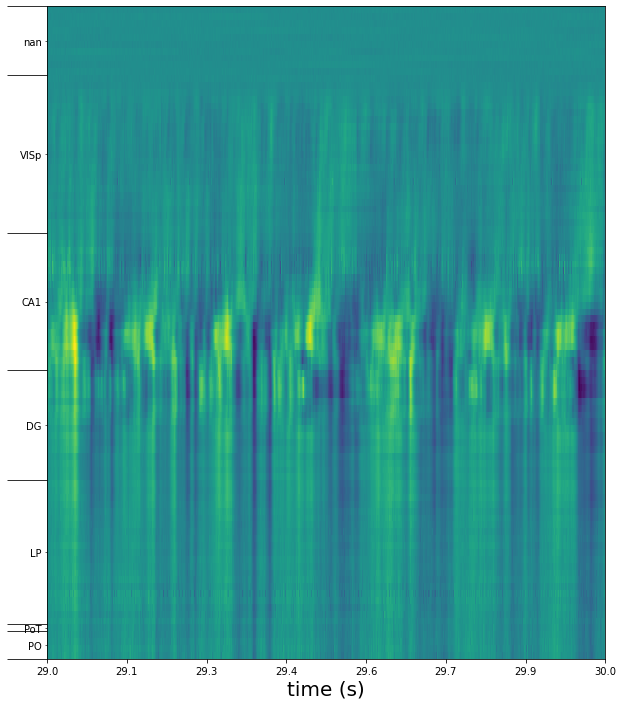

In [40]:
window = np.where(np.logical_and(lfp["time"] < 30, lfp["time"] >= 29))[0]

fig, ax = plt.subplots(figsize=(10,12))
ax.pcolormesh(lfp[{"time": window}].T)

ax.set_yticks(intervals)
ax.set_yticks(interval_midpoints, minor=True)
ax.set_yticklabels(structure_acronyms, minor=True)
ax.tick_params("y", which="major", labelleft=False, length=40)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(window), num_time_labels)).astype(int) - 1
time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
ax.set_xticks(time_label_indices + 0.5)
ax.set_xticklabels(time_labels)
ax.set_xlabel("time (s)", fontsize=20)

plt.show()

LFP time traces for structure CA1


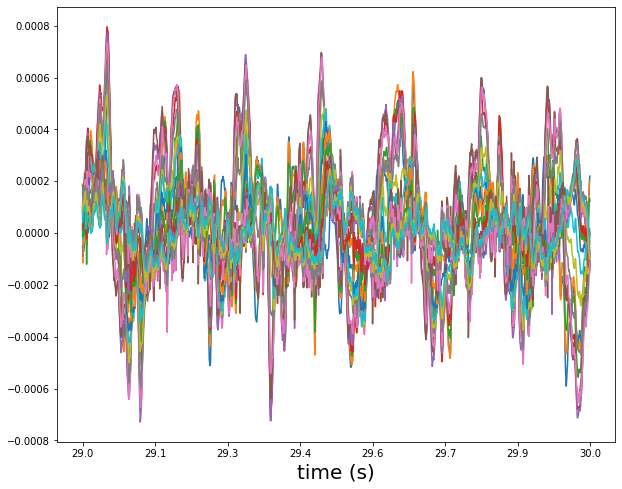

In [12]:
i = 4
print(f'LFP time traces for structure {structure_acronyms[i]}')

window = np.where(np.logical_and(lfp["time"] < 30, lfp["time"] >= 29))[0]
temp_lfp = lfp[{"time": window}]

time_range = [100,300]
visp_traces = temp_lfp[:,intervals[i]:intervals[i+1]]

plt.figure(figsize=(10,8))
plt.plot(visp_traces)

num_time_labels = 8
time_label_indices = np.around(np.linspace(1, len(window), num_time_labels)).astype(int) - 1
time_labels = [ f"{val:1.3}" for val in lfp["time"].values[window][time_label_indices]]
plt.gca().set_xticks(time_label_indices + 0.5)
plt.gca().set_xticklabels(time_labels)
plt.gca().set_xlabel("time (s)", fontsize=20)

plt.show()

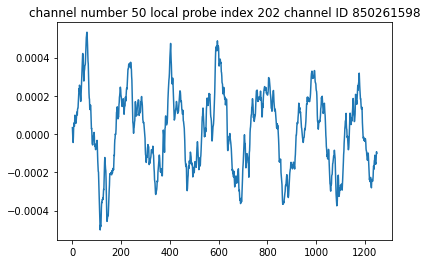

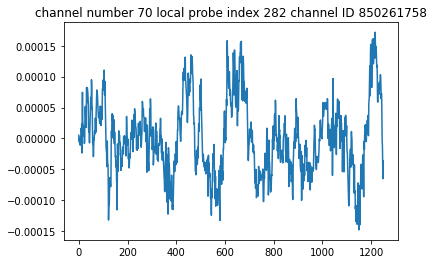

In [49]:
window1 = np.where(np.logical_and(lfp["time"] < 30, lfp["time"] >= 29))[0]

channel_num = 50 # CA1
plt.title(f"channel number {channel_num} local probe index {list(lfp_channel_dict.keys())[channel_num]} channel ID {lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]]}")
window2 = np.where(lfp['channel']==lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]])[0]
plt.plot(lfp[{"channel": window2, "time":window1}])
plt.show()

channel_num = 70 # VISp
plt.title(f"channel number {channel_num} local probe index {list(lfp_channel_dict.keys())[channel_num]} channel ID {lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]]}")
window2 = np.where(lfp['channel']==lfp_channel_dict[list(lfp_channel_dict.keys())[channel_num]])[0]
plt.plot(lfp[{"channel": window2, "time":window1}])
plt.show()

### current source density

C:\Users\sarfi\anaconda3\envs\allendata\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


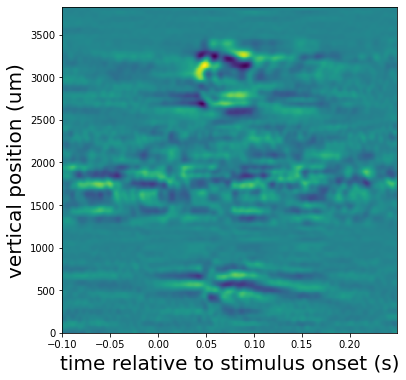

In [13]:
from scipy.ndimage.filters import gaussian_filter

csd = session.get_current_source_density(VISp_probe_id)

filtered_csd = gaussian_filter(csd.data, sigma=4)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolor(csd["time"], csd["vertical_position"], filtered_csd)

ax.set_xlabel("time relative to stimulus onset (s)", fontsize=20)
ax.set_ylabel("vertical position (um)", fontsize=20)

plt.show()

### locating layer 5

In [14]:
chosen_layer5 = [3000,3250]

In [53]:
channel_df = cache.get_channels()
channel_df = channel_df[channel_df['ecephys_probe_id']==VISp_probe_id]
print(len(channel_df))
channel_df.head()

372


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
850261194,810755801,0,43,20,7648.0,3645.0,7567.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261196,810755801,1,11,20,7651.0,3636.0,7566.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261198,810755801,2,59,40,7654.0,3627.0,7566.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,1
850261200,810755801,3,27,40,7657.0,3618.0,7565.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,3
850261202,810755801,4,43,60,7660.0,3610.0,7564.0,1020.0,PO,715093703,1249.999395,3a,29999.98547,True,2


In [16]:
layer5_channels_df = channel_df[(channel_df['probe_vertical_position']>=chosen_layer5[0]) & (channel_df['probe_vertical_position']<chosen_layer5[1])]
print(len(layer5_channels_df))
layer5_channels_df

# these channels are withing chosen layer 5 in terms of verical distance, but not all of them are associated with LFP recordings

25


,ecephys_probe_id,local_index,probe_horizontal_position,probe_vertical_position,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,ecephys_structure_id,ecephys_structure_acronym,ecephys_session_id,lfp_sampling_rate,phase,sampling_rate,has_lfp_data,unit_count
id,,,,,,,,,,,,,,,
850261790,810755801,298,59,3000,8685.0,991.0,8154.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261792,810755801,299,27,3000,8688.0,979.0,8153.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261794,810755801,300,43,3020,8690.0,968.0,8151.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261796,810755801,301,11,3020,8693.0,956.0,8150.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,1
850261798,810755801,302,59,3040,8696.0,944.0,8149.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261802,810755801,304,43,3060,8701.0,921.0,8146.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261804,810755801,305,11,3060,8704.0,910.0,8145.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261806,810755801,306,59,3080,8707.0,898.0,8143.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0
850261808,810755801,307,27,3080,8710.0,887.0,8142.0,385.0,VISp,715093703,1249.999395,3a,29999.98547,True,0


Checking which channels pulled from general channel list of this probe AND in vertical range established from CSD analysis (corresponding to layer 5), are available in full LFP trace time series data:

In [17]:
for ch in lfp.channel.data:
    if len(layer5_channels_df[layer5_channels_df.index==ch])!=0: print(ch, layer5_channels_df[layer5_channels_df.index==ch]['local_index'].item())
    # print(df[df.index==ch]['ecephys_probe_id'].item())

850261790 298
850261798 302
850261806 306
850261814 310
850261822 314
850261830 318
850261838 322
